# SK Part 3: Cross-Validation and Hyperparameter Tuning
* * *

In **SK Part 1**, we learn how to evaluate a machine learning model using the `train_test_split` function to split the full set into disjoint training and test sets based on a specified test size ratio. We then train the model (that is, "fit") using the training set and evaluate it against the test set. This approach is called "hold-out sampling". A more robust and methodical approach to hold-out sampling is "cross-validation", which is the subject of this tutorial.

A critical step in machine learning is to find out the "optimal" parameters of a learner (such as the number of neighbors in a KNN model). In this tutorial, we illustrate how optimal model parameters can be identified using repeated cross-validation in a grid search framework.

## Learning Objectives

- Implement various cross-validation strategies.

- Perform grid search to identify optimal hyperparameter values.


As in Part 1, we shall use the following datasets for regression, binary, and multiclass classification problems.

1. [Breast Cancer Wisconsin Data](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). The target feature is binary, i.e., if a cancer diagnosis is "malignant" or "benign".
2. [Boston Housing Data](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/). The target feature is continuous. The target is house prices in Boston in 1970's.
3. [Wine Data](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data). The target feature is multiclass. It consists of three types of wines in Italy.

We use KNN, DT, and NB models to illustrate how cross-validation is used to tune hyperparameters of a machine learning algorithm via grid search by going through the Breast Cancer Data and Boston Housing Data. We will leave Wine Data and other machine learning models as exercises.

## Table of Contents

* [Binary Classification Example: Breast Cancer Wisconsin Data](#1)
  - [Data Preparation](#1.0)
  - [Nearest Neigbor Models](#1.1)
  - [Cross-Validation](#1.2)
  - [KNN Hyperparameter Tuning and Visualization](#1.3)
  - [DT Hyperparameter Tuning and Visualization](#1.4)
  - [NB Hyperparameter Tuning and Visualization](#1.5)
* [Regression Example: Boston Housing Data](#2)
* [Exercises](#3)
  - [Problems](#3.1)
  - [Solutions](#3.2)

## Binary Classification Example: Breast Cancer Wisconsin Data <a class="anchor" id="1"></a>

### Data Preparation <a class="anchor" id="1.0"></a>

Let's prepare the dataset for modeling by performing the following:
- load the dataset from `sklearn` (unlike the Cloud version, this version does not have column names), 
- normalize the descriptive features so that they have 0 mean and 1 standard deviation, and
- split the dataset into training and test sets.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn import preprocessing

cancer_df = load_breast_cancer()
Data, target = cancer_df.data, cancer_df.target

Data = preprocessing.MinMaxScaler().fit_transform(Data)

# target is already encoded, but we need to reverse the labels
# so that malignant is the positive class
target = np.where(target==0, 1, 0)

D_train, D_test, t_train, t_test = train_test_split(Data, target, test_size = 0.3, random_state=999)

### Nearest Neighbor Models <a class="anchor" id="1.1"></a>

Let's fit a 1-nearest neighbor (1-NN) classifier (`n_neighbors=1`) using the Euclidean distance (`p=2`).

In [2]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=1, p=2)

knn_classifier.fit(D_train, t_train)
knn_classifier.score(D_test, t_test)

0.9473684210526315

The 1-NN classifier yields an accuracy score of around 94.7%. So, how can we improve this score? One way is to search the set of "hyperparameters" which produces the highest accuracy score. For a nearest neighbor model, the hyperparameters are as follows:

* Number of neighbors.
* Metric: Manhattan (p=1), Euclidean (p=2) or Minkowski (any p larger than 2). Technically, p=1 and p=2 are also Minkowski metrics, but in this notebook, we shall adopt the convention that the Minkowski metric corresponds to $p \geq 3$.

To search for the "best" set of hyperparameters, popular approaches are as follows:

* Random search: As its name suggests, it randomly selects the hyperparameter set to train models.
* Bayesian search: It is beyond the scope of this course. So we shall not cover it here.
* Grid search.

Grid search is the most common approach. It exhaustively searches through all possible combinations of hyperparameters during training the phase. For example, consider a KNN model. We can specify a grid of number of neighbors (K = 1, 2, 3) and two metrics (p=1, 2). The grid search starts training a model of K = 1 and p=1 and calculates its accuracy score. Then it moves to train models of (K = 2, p = 1), (K = 3, p = 1), (K = 1, p = 2), ..., and (K = 3, p = 2) and obtain their score values. Based on the accuracy scores, the grid search will rank the models and determine the set of hyperparameter values that give the highest accuracy score. 

Before we proceed further, we shall cover other cross-validation (CV) methods since tuning hyperparameters via grid search is usually cross-validated to avoid overfitting.

### Cross-Validation <a class="anchor" id="1.2"></a>

Two popular options for cross-validation are 5-fold and 10-fold. In 5-fold cross-validation, for instance, the entire dataset is partitioned into 5 equal-sized chunks. The first four chunks are used for training and the 5-th chunk is used for testing. Next, all the chunks other than the 4-th chunk are used for training and the 4-th chunk is used for testing, and so on. In the last iteration, all the chunks other than the 1-st chunk are used for training and the 1-st chunk is used for testing. The final step is to take the average of these 5 test accuracies and report it as the overall cross-validation accuracy. Please see the figure below for an illustration of a 10-fold cross-validation (source: [karlrosaen.com](http://karlrosaen.com/ml/learning-log/2016-06-20/)) . Please refer to Chapter 8 in the textbook for more information. 

<img src=http://karlrosaen.com/ml/learning-log/2016-06-20/k-fold-diagram.png width="600">

In contrast to hold-out-sampling, cross-validation is usually the preferred option due to the following two reasons:
* Sometimes there is just not enough data for a hold-out-sampling.
* Cross-validation reduces the risk of what is called "lucky split" where the difficult instances are put in the training partition and the easy instances are put in the test partition.

A downside of cross-validation is that it apparently requires more computer time. Also, if it happens to be the case that there is a good amount of data available already (say millions of rows), then the risk of "lucky split" diminishes and hold-out-sampling can be preferred. Another extension of cross-validation is repeated cross-validation (say 3 times) where data is partitioned into 5 equal-sized chunks multiple times and the cross-validation procedure is repeated, each time with a different partitioning of data per repeatition.

We can perform K-fold cross-validation by calling the `KFold` function imported from `sklearn.model_selection` module. It randomly splits the full dataset into K subsets or "folds". Then it trains the model on K-1 folds and evaluates the model against the remaining fold. This process is repeated exactly K times where each time a different fold is used for testing.

Other cross-validation variants from `scikit-learn` are as follows:

* `model_selection.RepeatedKFold()`: Repeated K-Fold cross-validator
* `model_selection.RepeatedStratifiedKFold()`: Repeated Stratified K-Fold cross-validator
* `model_selection.StratifiedKFold()`: Stratified K-Fold cross-validator
* `model_selection.LeaveOneOut()`: Leave One Out cross-validator

To learn more about cross-validators, please refer to [scikit-learn documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).

**Refresher questions**

1. What are the disadvantages of a simple test/ train split?
2. Can you tell the difference between the cross-validators above?

In the following example, we illustrate how we can conduct a stratified 5-fold (`n_splits = 5`) cross-validation with 3 repetitions (`n_repeats = 3`) using the `RepeatedStratifiedKFold` function. Since the target labels have fewer `malignant` labels than `benign`, stratification ensures that the proportion of the two labels in both train and test sets are the same as the proportion in the full dataset in each cross-validation repetition.

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

### KNN Hyperparameter Tuning and Visualization <a class="anchor" id="1.3"></a>

It's hyperparameter tuning time. First, we need to define a dictionary of KNN parameters for the grid search. Here, we will consider K values between 3 and 7 and $p$ values of 1 (Manhattan), 2 (Euclidean), and 5 (Minkowski).

In [4]:
import numpy as np
params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'p': [1, 2, 5]}

Second, we pass the `KNeighborsClassifier()` and `KNN_params` as the model and the parameter dictionary into the `GridSearchCV` function. In addition, we include the repeated stratified CV method we defined previously (`cv=cv_method`). Also, we tell `sklearn` which metric to optimize, which is accuracy in our example (`scoring='accuracy'`, `refit='accuracy'`).

In [5]:
from sklearn.model_selection import GridSearchCV

gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1,  # verbose: the higher, the more messages
                      scoring='accuracy', 
                      return_train_score=True)

The last step is to fit a KNN model using the full dataset.

In [6]:
gs_KNN.fit(Data, target);

Fitting 15 folds for each of 21 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:   19.2s finished


To get the best parameter values, we call the `best_params_` attribute.

In [7]:
gs_KNN.best_params_

{'n_neighbors': 3, 'p': 1}

After stratified 5-fold cross-validation with 3 repeatitions, we observe that the optimal parameters are 6 neighbors using the Manhattan (p=1) distance metric. The mean cross-validation accuracy with the optimal parameters can be extracted using the `best_score` attribute.

In [8]:
gs_KNN.best_score_

0.9748227500905656

To extract more cross-validation results, we can call `gs.csv_results` - a dictionary consisting of run details for each fold. 

In [9]:
gs_KNN.cv_results_['mean_test_score']

array([0.95136884, 0.95254878, 0.95021477, 0.9625317 , 0.95961807,
       0.95433939, 0.97482275, 0.97071883, 0.96135176, 0.96956477,
       0.97012886, 0.96429643, 0.97248357, 0.9689541 , 0.9619469 ,
       0.96721006, 0.96837448, 0.96428608, 0.97307354, 0.97012886,
       0.9619469 ])

Let's visualize the hyperparameter tuning results from the cross-validation. We define a data frame by combining `gs.cv_results_['params']` and `gs.cv_results_['mean_test_score']`. The `gs.cv_results_['params']` is an array of hyperparameter combinations. 

In [10]:
import pandas as pd

results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])

In [11]:
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']

Let's create a new column called "metric" that stores the name of the metric for each $p$ value.

In [12]:
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
results_KNN

,n_neighbors,p,test_score,metric
0,1,1,0.951369,Manhattan
1,1,2,0.952549,Euclidean
2,1,5,0.950215,Minkowski
3,2,1,0.962532,Manhattan
4,2,2,0.959618,Euclidean
5,2,5,0.954339,Minkowski
6,3,1,0.974823,Manhattan
7,3,2,0.970719,Euclidean
8,3,5,0.961352,Minkowski
9,4,1,0.969565,Manhattan


We visualize the results using the `matplotlib` module. The plot below shows that K = 3 with the Manhattan distance metric (p=1) outperforms other combinations.

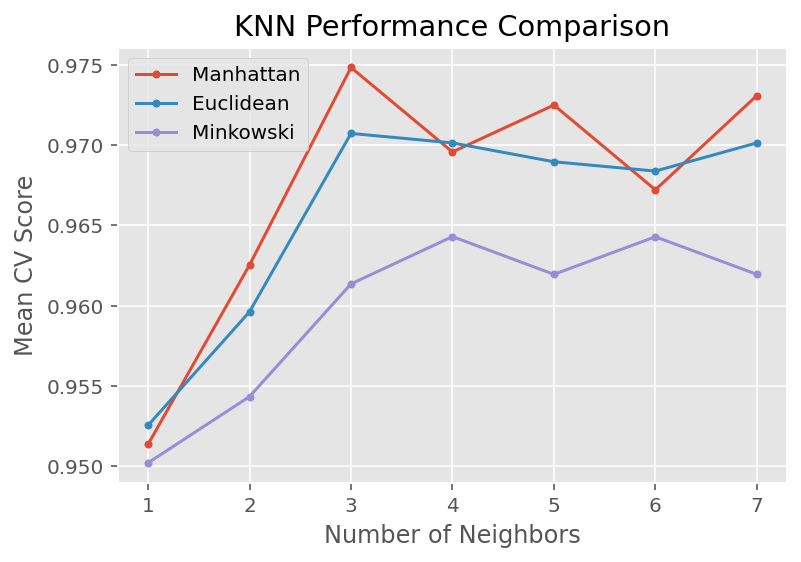

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

for i in ["Manhattan", "Euclidean", "Minkowski"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], marker = '.', label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel("Mean CV Score")
plt.title("KNN Performance Comparison")
plt.show()


### DT Hyperparameter Tuning and Visualization <a class="anchor" id="1.4"></a>

Let's fit a decision tree model and optimize its hyperparameters using a grid search. We shall perform a grid search over split criterion, maximum depth, and minimum samples split parameters.

In [14]:
from sklearn.tree import DecisionTreeClassifier

df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(Data, target);

Fitting 15 folds for each of 32 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    1.8s finished


Let's have a look at the best performing parameter combination.

In [15]:
gs_DT.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

In [16]:
gs_DT.best_score_

0.9338508513170833

Let's define a new data frame to store the DT grid search results for visualization.

In [17]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT.columns

Index(['criterion', 'max_depth', 'min_samples_split', 'test_score'], dtype='object')

Now let's do the plotting with respect to split criterion and maximum depth while taking the average of `min_samples_split` parameter.

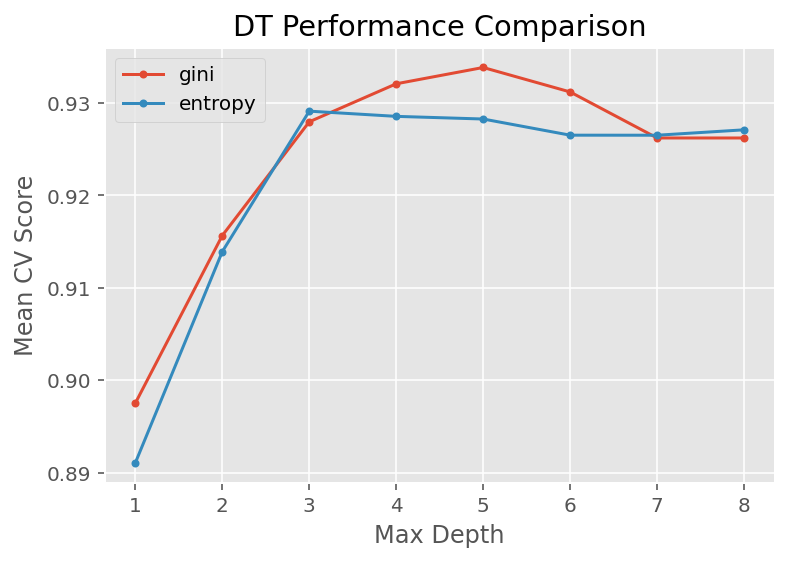

In [18]:

for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()




We observe that the best set of hyperparameters is as follows: entropy split criterion with a maximum depth of 4 and `min_samples_split` value of 2.

### NB Hyperparameter Tuning and Visualization <a class="anchor" id="1.5"></a>

Let's fit a Gaussian Naive Bayes model and optimize its only parameter, `var_smoothing`, using a grid search. Variance smoothing can be considered to be a variant of Laplace smoothing in the sense that the `var_smoothing` parameter specifies the portion of the largest variance of all features to be added to variances for calculation stability.

Recall that Gaussian NB assumes that each one of the descriptive features follows a Gaussian, that is, normal distribution. This is highly unlikely in practice, but we can perform what is called a "power transformation" on each feature to make it more or less normally distributed. The link [here](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/) is a good place to start learning about power transformations via its more specific case of Box-Cox transformations.

We perform power transformation using the `PowerTransformer` method in `sklearn`, but you need to make sure that you have the latest version of `sklearn` because this is a relatively new method. By default, `PowerTransformer` results in features that have a 0 mean and 1 standard deviation.

Let's first have a look at an example of a power transformation. We define an exponential random variable with a mean of 2 and sample 1000 numbers from this distribution. Numbers sampled from this distribution are always positive and this distribution is quite right skewed as you can see in the plot below. 

In [19]:
import numpy as np
from sklearn.preprocessing import PowerTransformer

np.random.seed(999)

sample_size = 1000
x_exponential = np.random.exponential(2, sample_size).reshape(-1, 1)
x_transformed = PowerTransformer().fit_transform(x_exponential)

df1 = pd.DataFrame(x_exponential)
df1['distribution'] = 'exponential'

df2 = pd.DataFrame(x_transformed)
df2['distribution'] = 'transformed'

# combine the two data frames into one to be used for plotting
df = pd.concat([df1, df2], axis=0)
df.rename(columns={0: 'x'}, inplace=True)

print(df.sample(n=10))

            x distribution
342 -0.276524  transformed
321  3.216755  exponential
247  1.297923  transformed
514 -1.678249  transformed
343  0.204341  exponential
386  0.486638  exponential
304  0.883091  exponential
772  0.015391  exponential
889  0.184597  transformed
554  0.076667  exponential


Once we perform a power transformation, we observe that the transformed numbers are centered at 0 and their distribution look like bell-curved.

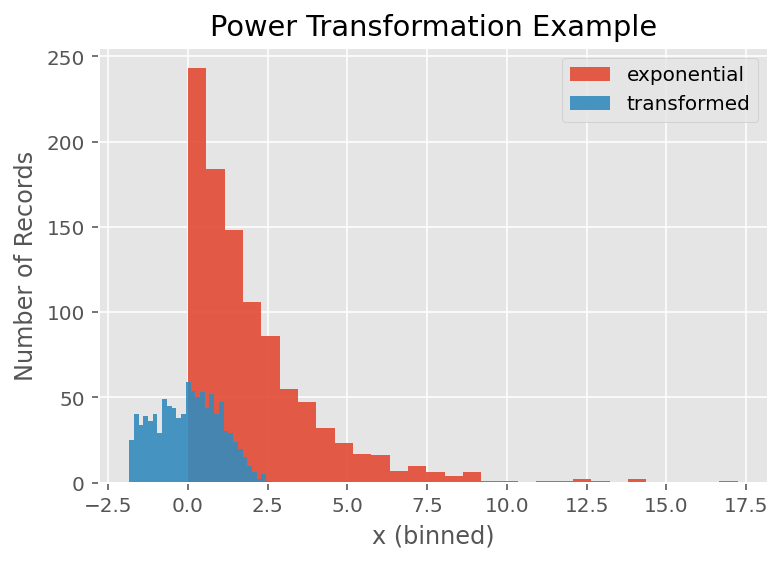

In [20]:
for i in ['exponential', 'transformed']:
    temp = df[df['distribution']==i]
    plt.hist(temp['x'], alpha = 0.9, bins =30, label = i)

plt.xlabel('x (binned)')
plt.ylabel('Number of Records')
plt.title('Power Transformation Example')
plt.legend()
plt.show()

The `var_smoothing` parameter's default value is $10^{-9}$. We will conduct the grid search in the "logspace", that is, we will search over the powers of 10. We will start with $10^0$ and end with $10^{-9}$ and we will try 100 different values. For this search, we will use the `logspace` function in the `numpy` module.

Here is how the logspace looks with 10 different values.

In [21]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [22]:
from sklearn.naive_bayes import GaussianNB

np.random.seed(999)

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(Data)

gs_NB.fit(Data_transformed, target);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    1.2s finished


In [23]:
gs_NB.best_params_

{'var_smoothing': 0.1}

In [24]:
gs_NB.best_score_

0.947891114216219

Let's define a new data frame to store the NB grid search results for visualization.

In [25]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

Now let's do the plotting with respect to the `var_smoothing` parameter. 

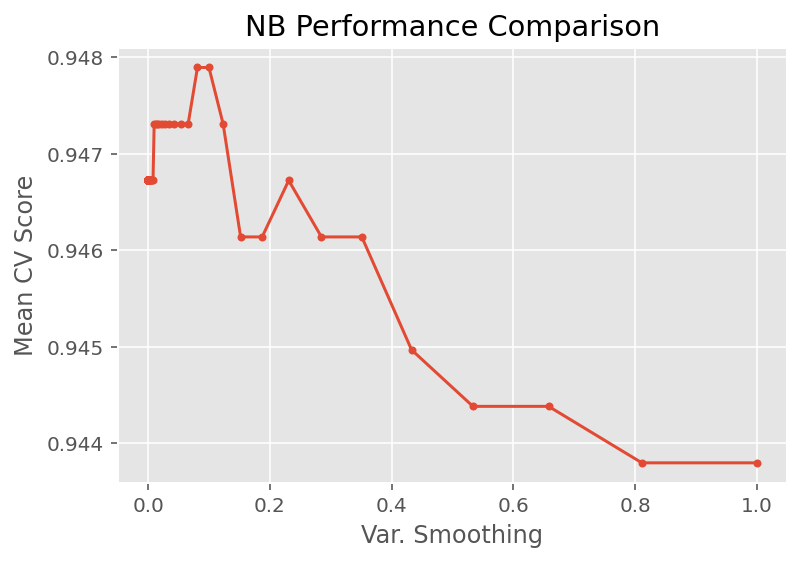

In [26]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

We observe that the best variance smoothing parameter for NB is 0.43, though the difference between other values in terms of the mean CV score is very small per the range of the y-axis.

## Regression Example: Boston Housing Data <a class="anchor" id="2"></a>

Let's consider the Boston housing dataset. We call `KNeighborsRegressor` to run KNN on this regression problem. The KNN regression grid search is similar to its classification counterpart except for the differences below.

* We can no longer use stratified K-fold validation since the target is not multiclass or binary. However, we can use other methods such as K-fold or Repeated K-fold.
* The model performance metric is no longer "accuracy", but MSE (Mean Squared Error). We do not need to specify "mse" in `GridSearchCV` since `sklearn` is smart enough to figure out that the target is a continuous variable.

In [27]:
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsRegressor

housing_data = load_boston()
Data, target = housing_data.data, housing_data.target

In [28]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

cv_method = RepeatedKFold(n_splits=5, 
                          n_repeats=3, 
                          random_state=999)

Data = StandardScaler().fit_transform(Data)

knn_regressor = KNeighborsRegressor()

params_knn_regressor = {'n_neighbors': [1,2,3,4,5], 
                        'p': [1, 2, 5]}

gs_knn_regressor = GridSearchCV(estimator=knn_regressor, 
                  param_grid=params_knn_regressor, 
                  verbose=1, 
                  cv=cv_method)

gs_knn_regressor.fit(Data, target);

Fitting 15 folds for each of 15 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:    0.6s finished


After 3 repeated 5-fold cross-validation, we observe that the best parameters and best score are as follows.

In [29]:
gs_knn_regressor.best_params_

{'n_neighbors': 3, 'p': 1}

In [30]:
gs_knn_regressor.best_score_

0.8037919382184404

## Exercises <a class="anchor" id="3"></a>

### Problem <a class="anchor" id="3.1"></a>

Run a decision tree model on Wine Data and tune its hyperparameters using a stratified repeated CV.

### Possible Solution <a class="anchor" id="3.2"></a>

```
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

wine = load_wine()
Data, target = wine.data, wine.target

Data = StandardScaler().fit_transform(Data)

cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 3, 
                                    random_state = 999)

dt_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [2, 3, 4, 5]}

gs = GridSearchCV(estimator=dt_classifier, 
                  param_grid=params_DT, 
                  cv=cv_method,
                  verbose=1, 
                  scoring='accuracy')                  

print(gs.fit(Data, target))
print(gs.best_params_)
print(gs.best_score_)

```

***
www.featureranking.com